In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2018-05-20 15:49:48,454 : INFO : 'pattern' package not found; tag filters are not available for English


In [2]:
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM
from keras.layers import Dropout, GlobalAveragePooling1D
from keras.layers import Flatten, Activation, Concatenate
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:100000]
test_batch = test_data[0:50000]

In [5]:
def build_sentences_vector(sentence):
    words = sentence.split()
    result = np.zeros(100)
    size = 0
    for word in words:
        if word in embeding_model.wv.vocab:
            result+=embeding_model.wv[word]
            size+=1
    if size == 0:
        size = 1
    result /= size
    return result

In [6]:
embeding_model = Word2Vec.load('Yelp_embedings')
len(embeding_model.wv.vocab)

2018-05-20 15:52:10,373 : INFO : loading Word2Vec object from Yelp_embedings
2018-05-20 15:52:13,984 : INFO : loading wv recursively from Yelp_embedings.wv.* with mmap=None
2018-05-20 15:52:13,984 : INFO : setting ignored attribute vectors_norm to None
2018-05-20 15:52:13,986 : INFO : loading vocabulary recursively from Yelp_embedings.vocabulary.* with mmap=None
2018-05-20 15:52:13,987 : INFO : loading trainables recursively from Yelp_embedings.trainables.* with mmap=None
2018-05-20 15:52:13,988 : INFO : setting ignored attribute cum_table to None
2018-05-20 15:52:13,989 : INFO : loaded Yelp_embedings


101865

In [7]:
%%time
train_data_features = []
for sentense in train_batch.text:
    train_data_features.append(build_sentences_vector(sentense))
test_data_transform = []
for sentense in test_batch.text:
    test_data_transform.append(build_sentences_vector(sentense))

CPU times: user 1min 26s, sys: 231 ms, total: 1min 26s
Wall time: 1min 26s


In [8]:
train_data_features = pd.DataFrame(train_data_features)
test_data_transform = pd.DataFrame(test_data_transform)

In [9]:
%%time
big_X = train_data_features.append(test_data_transform)
scaler = MinMaxScaler()
scaler.fit(big_X)
train_data_features = scaler.transform(train_data_features)
test_data_transform = scaler.transform(test_data_transform)

CPU times: user 222 ms, sys: 208 ms, total: 431 ms
Wall time: 430 ms


In [10]:
print(train_data_features.shape, test_data_transform.shape)
print(train_data_features[0].shape, test_data_transform[0].shape)

(100000, 100) (50000, 100)
(100,) (100,)


In [11]:
train_data_features[0]

array([0.47768725, 0.50261539, 0.7106637 , 0.60011637, 0.30857185,
       0.46072202, 0.58532382, 0.35489181, 0.56592655, 0.52509615,
       0.34207966, 0.46469938, 0.28336177, 0.48729129, 0.56763504,
       0.48545882, 0.3633329 , 0.50221415, 0.4790287 , 0.44466971,
       0.60395302, 0.21026502, 0.71012634, 0.61785903, 0.32811395,
       0.40180564, 0.42955268, 0.52559043, 0.41086256, 0.41418741,
       0.7674902 , 0.54301586, 0.61783318, 0.58074126, 0.55888046,
       0.54453445, 0.36168717, 0.54021471, 0.45886499, 0.64497301,
       0.68964035, 0.66150094, 0.42380001, 0.29542307, 0.2645298 ,
       0.64970587, 0.59399217, 0.70192113, 0.67110966, 0.66881021,
       0.52171434, 0.47996132, 0.52243193, 0.59537827, 0.46571829,
       0.55339619, 0.73363276, 0.42394804, 0.23819312, 0.43204729,
       0.68764806, 0.66526823, 0.39650339, 0.48692192, 0.21172303,
       0.69001408, 0.35145527, 0.39906459, 0.34272367, 0.48391983,
       0.44863189, 0.6544023 , 0.37294765, 0.48754314, 0.75848

In [36]:
batch_size = 100
num_classes = 6
epochs = 5
text_x, text_y = 10, 10
train_data_features[0].shape
x_train = train_data_features.reshape(train_data_features.shape[0], text_x, text_y)
y_train = test_data_transform.reshape(test_data_transform.shape[0], text_x, text_y)
input_shape = (text_x, text_y)

In [26]:
x_train.shape

(100000, 10, 10)

In [27]:
input_shape

(10, 10)

In [44]:
data_dim = 10
timesteps = 10

model = Sequential()
model.add(LSTM(16, return_sequences=True, stateful=True, batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(LSTM(16, return_sequences=True, stateful=True))
model.add(LSTM(32, return_sequences=True, stateful=True))
model.add(LSTM(32, return_sequences=True, stateful=True))
model.add(LSTM(64, return_sequences=True, stateful=True))
model.add(LSTM(64, return_sequences=True, stateful=True))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(LSTM(128, return_sequences=True, stateful=True))
model.add(LSTM(256, return_sequences=True, stateful=True))
model.add(LSTM(256, return_sequences=True, stateful=True))
model.add(LSTM(256, return_sequences=True, stateful=True))
model.add(LSTM(256, stateful=True))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (100, 10, 16)             1728      
_________________________________________________________________
lstm_35 (LSTM)               (100, 10, 16)             2112      
_________________________________________________________________
lstm_36 (LSTM)               (100, 10, 32)             6272      
_________________________________________________________________
lstm_37 (LSTM)               (100, 10, 32)             8320      
_________________________________________________________________
lstm_38 (LSTM)               (100, 10, 64)             24832     
_________________________________________________________________
lstm_39 (LSTM)               (100, 10, 64)             33024     
_________________________________________________________________
lstm_40 (LSTM)               (100, 10, 128)            98816     
__________

In [29]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
history = AccuracyHistory()

In [30]:
Y = np_utils.to_categorical(train_batch.stars)

In [45]:
%%time
model.fit(x_train, np.array(Y),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.15,
          callbacks=[history])

Train on 85000 samples, validate on 15000 samples
Epoch 1/5
85000/85000 [==============================] - 858s 10ms/step - loss: 1.4482 - acc: 0.4298 - val_loss: 1.4378 - val_acc: 0.4267
Epoch 2/5
85000/85000 [==============================] - 857s 10ms/step - loss: 1.4362 - acc: 0.4310 - val_loss: 1.4480 - val_acc: 0.4267
Epoch 3/5
85000/85000 [==============================] - 815s 10ms/step - loss: 1.4376 - acc: 0.4310 - val_loss: 1.4362 - val_acc: 0.4267
Epoch 4/5
85000/85000 [==============================] - 830s 10ms/step - loss: 1.4530 - acc: 0.4232 - val_loss: 1.4623 - val_acc: 0.4267
Epoch 5/5
85000/85000 [==============================] - 807s 9ms/step - loss: 1.4747 - acc: 0.4080 - val_loss: 1.4772 - val_acc: 0.2320
CPU times: user 2h 52min 57s, sys: 12min 43s, total: 3h 5min 40s
Wall time: 1h 9min 34s


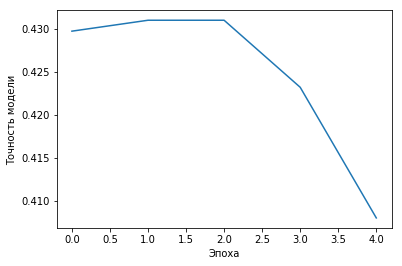

In [46]:
plt.plot(range(epochs), history.acc)
plt.xlabel('Эпоха')
plt.ylabel('Точность модели')
plt.show()